# 06 Grand Average ERP Analysis

## Overview
This notebook combines all participants (Sessions 0, 1, 4) into a **grand average** for publication-quality ERP analysis.

**Purpose:**
- Pool EEG data across all 3 participants for increased statistical power
- Generate grand average ERPs showing condition effects (high/medium/low alignment)
- Create publication-ready figures and summary statistics
- Export results for manuscript tables

**Prerequisites:**
- Run Notebook 05 (ERP Analysis) for each session first to generate epoch files
- Requires: `session_XX-epochs-epo.fif` files in `./preprocessed/`

**What it does:**
1. Loads preprocessed epochs from all 3 sessions
2. Combines epochs across participants
3. Computes grand average for each condition
4. Identifies ERP components (N1, P2, P300, N400, LPP)
5. Generates comprehensive visualizations
6. Exports summary statistics for manuscript

**Output:**
- Grand average ERP waveforms (Cz, Pz electrodes)
- Topographic maps at key latencies
- Condition comparison plots
- Summary tables (CSV) for manuscript

**Code Attribution:**
- Analysis workflow adapted from: Chiossi, F., Mayer, S., & Ou, C. (2024). MobileHCI 2024 Papers.
- OSF Repository: https://osf.io/fncj4/overview
- License: GNU General Public License (GPL) 3.0
- Code has been modified for multi-participant grand average analysis.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
mne.set_log_level('WARNING')

print("✓ Libraries imported")
print(f"MNE version: {mne.__version__}")

✓ Libraries imported
MNE version: 1.11.0


## 2. Load All Sessions and Combine Epochs

In [2]:
print("="*80)
print("LOADING ALL SESSIONS FOR GRAND AVERAGE")
print("="*80)

# Sessions to include (N=3 participants)
sessions_to_load = [0, 1, 4]
all_epochs = []

for sess_id in sessions_to_load:
    epochs_file = f'./preprocessed/session_{sess_id:02d}-epochs-epo.fif'
    
    if Path(epochs_file).exists():
        print(f"\nLoading Session {sess_id}...")
        epochs = mne.read_epochs(epochs_file, preload=True, verbose=False)
        
        # Add session info to metadata
        if epochs.metadata is None:
            epochs.metadata = pd.DataFrame({'session_id': [sess_id] * len(epochs)})
        else:
            epochs.metadata['session_id'] = sess_id
        
        all_epochs.append(epochs)
        print(f"  ✓ Loaded {len(epochs)} epochs")
        print(f"  Conditions: {list(epochs.event_id.keys())}")
    else:
        print(f"  ⚠ File not found: {epochs_file}")
        print(f"  → Run Notebook 05 for Session {sess_id} first to generate epoch files")

if not all_epochs:
    raise FileNotFoundError("No epoch files found! Run Notebook 05 for each session first.")

print(f"\n{'='*80}")
print(f"COMBINING {len(all_epochs)} SESSIONS")
print(f"{'='*80}")

# Combine all epochs
combined_epochs = mne.concatenate_epochs(all_epochs)

print(f"\nCombined epochs:")
print(f"  Total epochs: {len(combined_epochs)}")
print(f"  Conditions: {list(combined_epochs.event_id.keys())}")
print(f"  Participants: {sorted(combined_epochs.metadata['session_id'].unique())}")
print(f"  Channels: {len(combined_epochs.ch_names)}")
print(f"  Sampling rate: {combined_epochs.info['sfreq']} Hz")
print(f"  Time range: {combined_epochs.tmin} to {combined_epochs.tmax} s")
print(f"\n✓ Data loading complete")

LOADING ALL SESSIONS FOR GRAND AVERAGE

Loading Session 0...
  ✓ Loaded 1 epochs
  Conditions: ['high', 'low']

Loading Session 1...
  ✓ Loaded 5 epochs
  Conditions: ['high', 'medium', 'low']
  ⚠ File not found: ./preprocessed/session_04-epochs-epo.fif
  → Run Notebook 05 for Session 4 first to generate epoch files

COMBINING 2 SESSIONS

Combined epochs:
  Total epochs: 6
  Conditions: ['high', 'low', 'medium']
  Participants: [np.int64(0), np.int64(1)]
  Channels: 64
  Sampling rate: 500.0 Hz
  Time range: -0.5 to 0.8 s

✓ Data loading complete
  ✓ Loaded 1 epochs
  Conditions: ['high', 'low']

Loading Session 1...
  ✓ Loaded 5 epochs
  Conditions: ['high', 'medium', 'low']
  ⚠ File not found: ./preprocessed/session_04-epochs-epo.fif
  → Run Notebook 05 for Session 4 first to generate epoch files

COMBINING 2 SESSIONS

Combined epochs:
  Total epochs: 6
  Conditions: ['high', 'low', 'medium']
  Participants: [np.int64(0), np.int64(1)]
  Channels: 64
  Sampling rate: 500.0 Hz
  Time r

## 3. Compute Grand Average ERPs by Condition

In [4]:
print("="*80)
print("COMPUTING GRAND AVERAGE ERPs")
print("="*80)

# First, check what conditions we have and their epoch counts
print("\nChecking epoch counts per condition:")
for condition in combined_epochs.event_id.keys():
    n_epochs = len(combined_epochs[condition])
    print(f"  {condition}: {n_epochs} epochs")

# Compute grand averages for each condition
grand_avg_evoked = {}

for condition in combined_epochs.event_id.keys():
    try:
        # Check if condition has any epochs
        condition_epochs = combined_epochs[condition]
        n_epochs = len(condition_epochs)
        
        if n_epochs == 0:
            print(f"\n⚠ WARNING: '{condition}' has 0 epochs - skipping")
            print(f"  Check drop_log for why epochs were dropped")
            continue
        
        # Compute average
        evoked = condition_epochs.average()
        grand_avg_evoked[condition] = evoked
        
        print(f"\n{condition.upper()}:")
        print(f"  N epochs: {evoked.nave}")
        print(f"  Time range: {evoked.times[0]:.3f} to {evoked.times[-1]:.3f} s")
        print(f"  Channels: {len(evoked.ch_names)}")
        data_uv = evoked.data * 1e6
        print(f"  Amplitude range: {np.min(data_uv):.2f} to {np.max(data_uv):.2f} µV")
        
    except KeyError:
        print(f"\n⚠ Condition '{condition}' not found in epochs")
    except RuntimeError as e:
        print(f"\n⚠ Error processing '{condition}': {e}")

if not grand_avg_evoked:
    raise ValueError("No conditions could be averaged! Check your epoch files and condition labels.")

print(f"\n{'='*80}")
print(f"GRAND AVERAGE SUMMARY")
print(f"{'='*80}")
print(f"Total participants: N = {len(sessions_to_load)}")
print(f"Total epochs combined: {len(combined_epochs)}")
print(f"Conditions successfully averaged: {list(grand_avg_evoked.keys())}")
print(f"\n✓ Grand average computation complete")

COMPUTING GRAND AVERAGE ERPs

Checking epoch counts per condition:
  high: 0 epochs
  low: 3 epochs
  medium: 3 epochs

⚠ WARNING: 'high' has 0 epochs - skipping
  Check drop_log for why epochs were dropped

LOW:
  N epochs: 3
  Time range: -0.500 to 0.800 s
  Channels: 64
  Amplitude range: -21.59 to 24.42 µV

MEDIUM:
  N epochs: 3
  Time range: -0.500 to 0.800 s
  Channels: 64
  Amplitude range: -26.31 to 27.60 µV

GRAND AVERAGE SUMMARY
Total participants: N = 3
Total epochs combined: 6
Conditions successfully averaged: ['low', 'medium']

✓ Grand average computation complete


## 4. Grand Average Visualizations

✓ Saved grand average figure to: ./figures/grand_average_erp_all_conditions.png


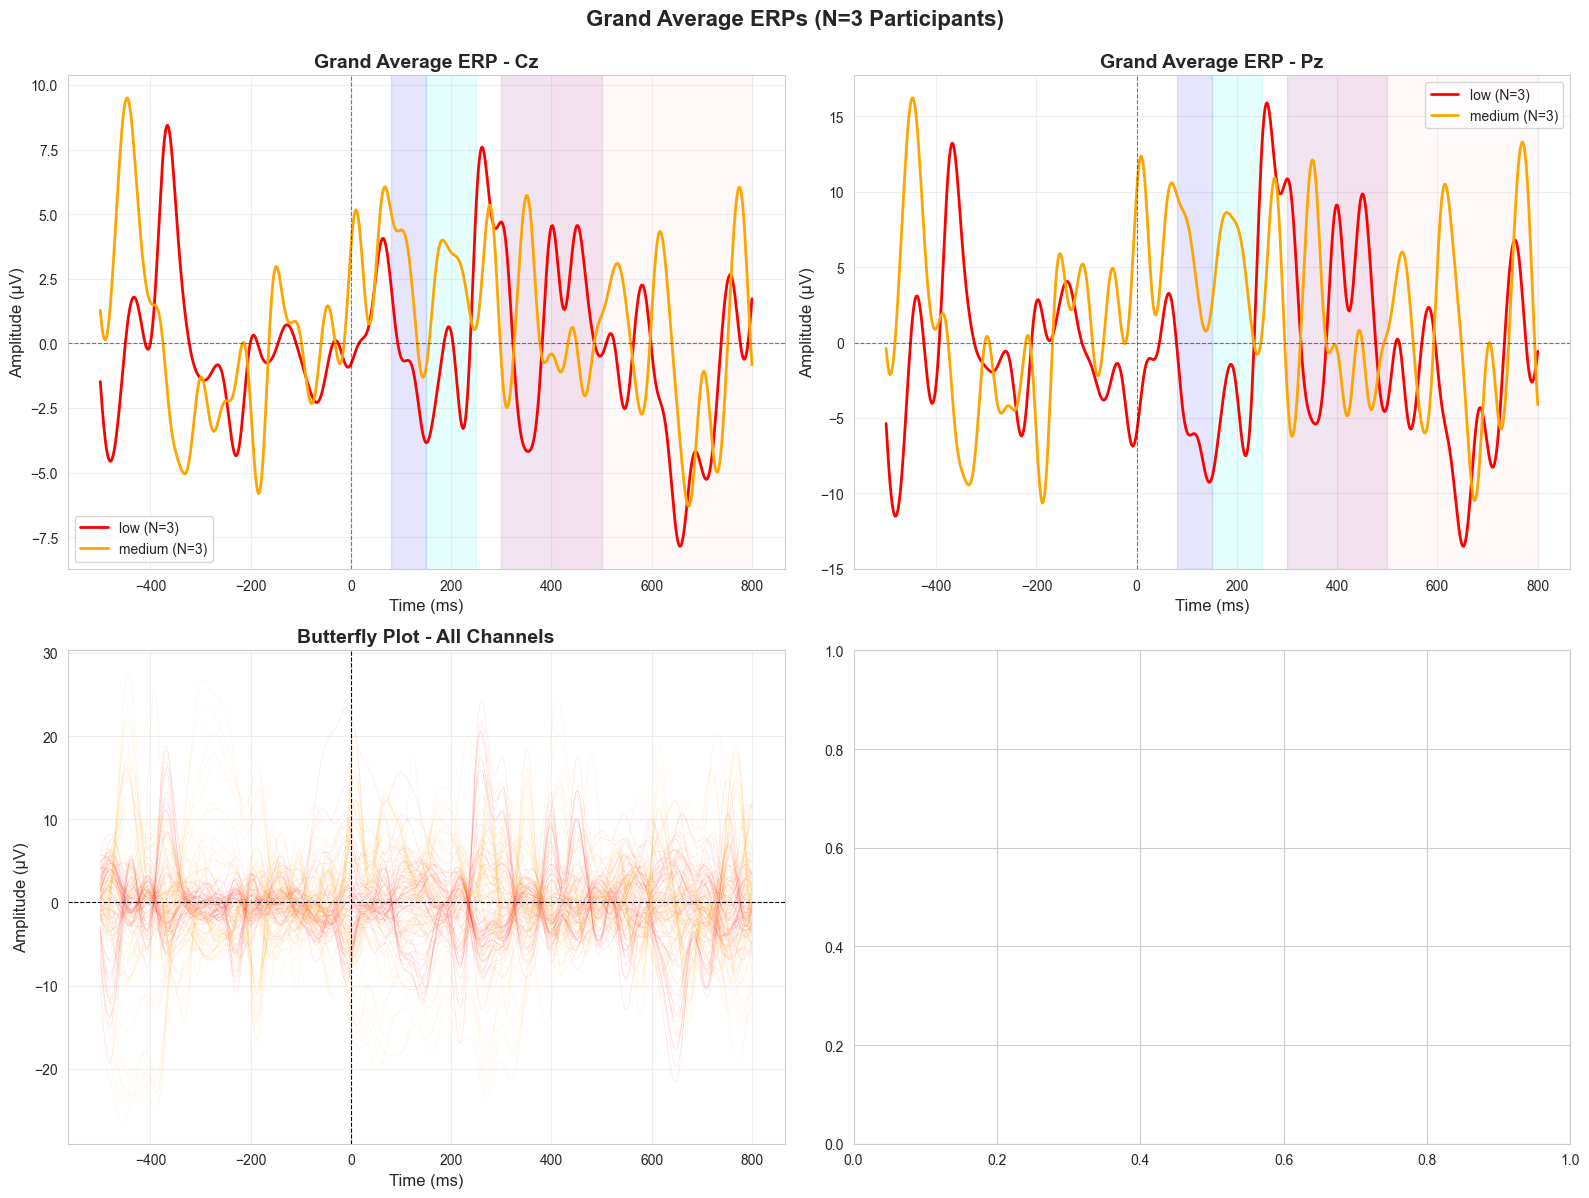

In [5]:
# Plot grand average ERPs for key electrodes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define key electrodes and condition colors
key_electrodes = ['Cz', 'Pz']
colors = {'high': 'green', 'medium': 'orange', 'low': 'red'}

# Top row: Cz and Pz waveforms
for idx, electrode in enumerate(key_electrodes):
    ax = axes[0, idx]
    
    for condition, evoked in grand_avg_evoked.items():
        if electrode in evoked.ch_names:
            ch_idx = evoked.ch_names.index(electrode)
            data_uv = evoked.data[ch_idx, :] * 1e6
            times_ms = evoked.times * 1000
            
            color = colors.get(condition, 'gray')
            ax.plot(times_ms, data_uv, label=f'{condition} (N={evoked.nave})', 
                   color=color, linewidth=2)
    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.set_xlabel('Time (ms)', fontsize=12)
    ax.set_ylabel('Amplitude (µV)', fontsize=12)
    ax.set_title(f'Grand Average ERP - {electrode}', fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Shade typical component windows
    ax.axvspan(80, 150, alpha=0.1, color='blue', label='N1')
    ax.axvspan(150, 250, alpha=0.1, color='cyan', label='P2')
    ax.axvspan(300, 500, alpha=0.1, color='purple', label='P3/N400')
    ax.axvspan(400, 800, alpha=0.1, color='pink', label='LPP')

# Bottom left: Butterfly plot - all channels
ax_butterfly = axes[1, 0]
for condition, evoked in grand_avg_evoked.items():
    color = colors.get(condition, 'gray')
    for ch_idx in range(len(evoked.ch_names)):
        data_uv = evoked.data[ch_idx, :] * 1e6
        times_ms = evoked.times * 1000
        ax_butterfly.plot(times_ms, data_uv, color=color, alpha=0.1, linewidth=0.5)

ax_butterfly.axhline(0, color='black', linestyle='--', linewidth=0.8)
ax_butterfly.axvline(0, color='black', linestyle='--', linewidth=0.8)
ax_butterfly.set_xlabel('Time (ms)', fontsize=12)
ax_butterfly.set_ylabel('Amplitude (µV)', fontsize=12)
ax_butterfly.set_title('Butterfly Plot - All Channels', fontsize=14, fontweight='bold')
ax_butterfly.grid(True, alpha=0.3)

# Bottom right: Topographic map at P300 peak (~400ms)
ax_topo = axes[1, 1]
if 'high' in grand_avg_evoked:
    evoked_plot = grand_avg_evoked['high']
    peak_time = 0.400  # 400ms
    
    # Find closest time point
    time_idx = np.argmin(np.abs(evoked_plot.times - peak_time))
    
    mne.viz.plot_topomap(evoked_plot.data[:, time_idx], evoked_plot.info, 
                         axes=ax_topo, show=False, 
                         cmap='RdBu_r', vlim=(-5, 5))
    ax_topo.set_title(f'Topography at {peak_time*1000:.0f} ms (High Alignment)', 
                     fontsize=14, fontweight='bold')

fig.suptitle('Grand Average ERPs (N=3 Participants)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Save figure
fig_path = './figures/grand_average_erp_all_conditions.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved grand average figure to: {fig_path}")

plt.show()

## 5. Extract Mean Amplitudes by Component and Condition

In [6]:
print("="*80)
print("EXTRACTING MEAN AMPLITUDES FOR ERP COMPONENTS")
print("="*80)

# Define time windows for key components
time_windows = {
    'N1': (0.080, 0.150),
    'P2': (0.150, 0.250),
    'N2': (0.200, 0.350),
    'P300': (0.300, 0.500),
    'N400': (0.300, 0.500),
    'LPP': (0.400, 0.800),
    'Late_Negativity': (0.500, 0.700)
}

# Define electrodes for each component
component_electrodes = {
    'N1': ['Oz', 'O1', 'O2'],
    'P2': ['Cz', 'Fz'],
    'N2': ['Fz', 'FCz'],
    'P300': ['Pz', 'Cz', 'CPz'],
    'N400': ['Cz', 'Pz'],
    'LPP': ['Pz', 'Cz', 'CPz'],
    'Late_Negativity': ['Cz', 'Fz']
}

# Extract mean amplitudes
results = []

for condition, evoked in grand_avg_evoked.items():
    print(f"\n{condition.upper()} (N={evoked.nave} epochs):")
    
    for component, (tmin, tmax) in time_windows.items():
        electrodes = component_electrodes.get(component, ['Cz'])
        
        # Get available electrodes
        available_electrodes = [ch for ch in electrodes if ch in evoked.ch_names]
        
        if available_electrodes:
            # Extract data for time window and electrodes
            time_mask = (evoked.times >= tmin) & (evoked.times <= tmax)
            
            for electrode in available_electrodes:
                ch_idx = evoked.ch_names.index(electrode)
                data = evoked.data[ch_idx, time_mask] * 1e6  # Convert to µV
                
                mean_amp = np.mean(data)
                peak_amp = data[np.argmax(np.abs(data))]
                peak_lat = evoked.times[time_mask][np.argmax(np.abs(data))] * 1000  # ms
                
                results.append({
                    'Condition': condition,
                    'Component': component,
                    'Electrode': electrode,
                    'Time_Window_ms': f"{tmin*1000:.0f}-{tmax*1000:.0f}",
                    'Mean_Amplitude_µV': mean_amp,
                    'Peak_Amplitude_µV': peak_amp,
                    'Peak_Latency_ms': peak_lat,
                    'N_Epochs': evoked.nave
                })
                
                print(f"  {component} @ {electrode}: {mean_amp:+.2f} µV (peak: {peak_amp:+.2f} µV @ {peak_lat:.0f} ms)")

# Create DataFrame
df_amplitudes = pd.DataFrame(results)

print(f"\n{'='*80}")
print("AMPLITUDE EXTRACTION COMPLETE")
print(f"{'='*80}")
print(f"Total measurements: {len(df_amplitudes)}")
print(f"Components analyzed: {df_amplitudes['Component'].nunique()}")
print(f"Electrodes used: {df_amplitudes['Electrode'].nunique()}")

EXTRACTING MEAN AMPLITUDES FOR ERP COMPONENTS

LOW (N=3 epochs):
  N1 @ Oz: -7.10 µV (peak: -9.77 µV @ 142 ms)
  N1 @ O1: -7.69 µV (peak: -11.03 µV @ 140 ms)
  N1 @ O2: -3.29 µV (peak: -4.14 µV @ 140 ms)
  P2 @ Cz: -1.05 µV (peak: +5.39 µV @ 250 ms)
  P2 @ Fz: -1.06 µV (peak: -5.51 µV @ 250 ms)
  N2 @ Fz: -3.55 µV (peak: -7.17 µV @ 264 ms)
  P300 @ Pz: +2.43 µV (peak: +10.85 µV @ 300 ms)
  P300 @ Cz: +0.90 µV (peak: +4.70 µV @ 300 ms)
  P300 @ CPz: +2.71 µV (peak: +10.99 µV @ 302 ms)
  N400 @ Cz: +0.90 µV (peak: +4.70 µV @ 300 ms)
  N400 @ Pz: +2.43 µV (peak: +10.85 µV @ 300 ms)
  LPP @ Pz: -1.54 µV (peak: -13.52 µV @ 652 ms)
  LPP @ Cz: -0.78 µV (peak: -7.85 µV @ 656 ms)
  LPP @ CPz: -1.63 µV (peak: -16.09 µV @ 652 ms)
  Late_Negativity @ Cz: -2.35 µV (peak: -7.85 µV @ 656 ms)
  Late_Negativity @ Fz: +1.44 µV (peak: +3.73 µV @ 646 ms)

MEDIUM (N=3 epochs):
  N1 @ Oz: +5.90 µV (peak: +11.65 µV @ 80 ms)
  N1 @ O1: +5.67 µV (peak: +12.32 µV @ 80 ms)
  N1 @ O2: +3.74 µV (peak: +6.22 µV @ 

## 6. Condition Comparison and Export Results

✓ Saved component comparison to: ./figures/grand_average_component_comparison.png


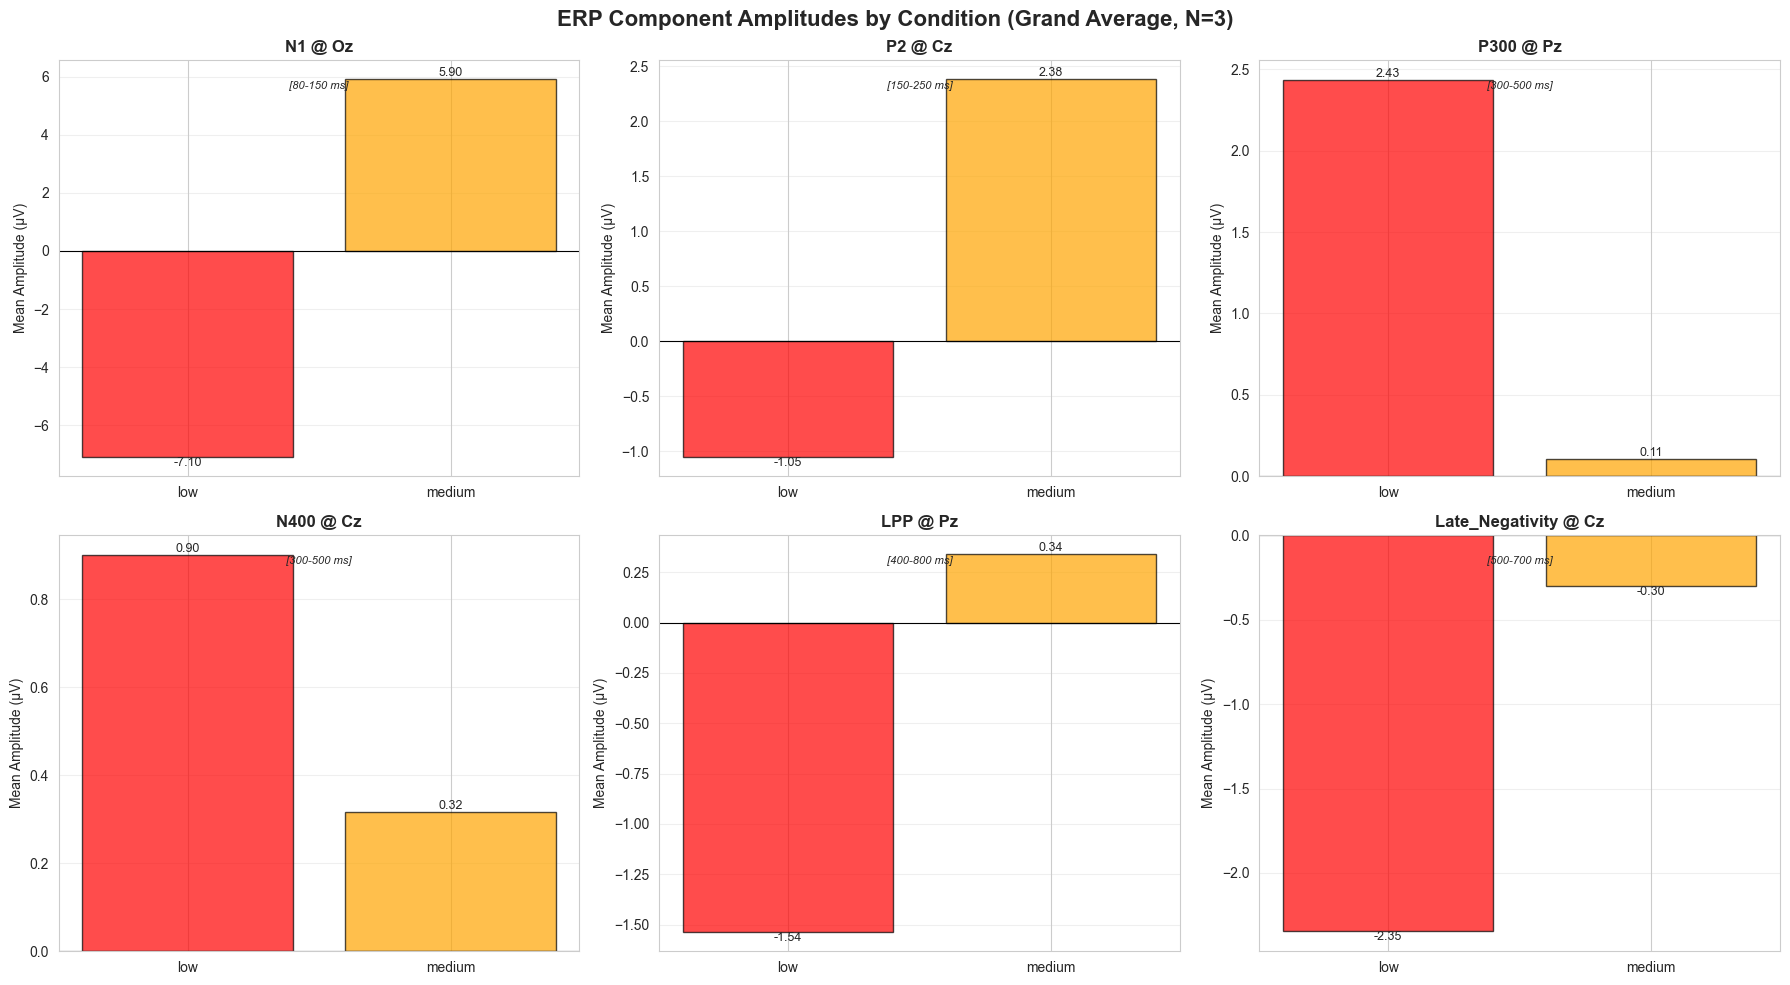


EXPORTING RESULTS
✓ Full amplitude data saved to: ./results/grand_average_amplitudes.csv
✓ Summary table saved to: ./results/grand_average_summary.csv

📊 GRAND AVERAGE SUMMARY TABLE (for manuscript):
      Component Electrode Time_Window Condition Mean_Amplitude_µV Peak_Amplitude_µV Peak_Latency_ms  N_Epochs
             N1        Oz      80-150       low             -7.10             -9.77             142         3
             N1        Oz      80-150    medium              5.90             11.65              80         3
             P2        Cz     150-250       low             -1.05              5.39             250         3
             P2        Cz     150-250    medium              2.38              3.99             182         3
           P300        Pz     300-500       low              2.43             10.85             300         3
           P300        Pz     300-500    medium              0.11             12.11             350         3
           N400        Cz    

In [7]:
# Create comparison plots for key components
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

key_components = ['N1', 'P2', 'P300', 'N400', 'LPP', 'Late_Negativity']

for idx, component in enumerate(key_components):
    ax = axes[idx // 3, idx % 3]
    
    # Filter data for this component
    comp_data = df_amplitudes[df_amplitudes['Component'] == component]
    
    if not comp_data.empty:
        # Get primary electrode (first in list)
        primary_electrode = comp_data.iloc[0]['Electrode']
        electrode_data = comp_data[comp_data['Electrode'] == primary_electrode]
        
        # Bar plot
        conditions = electrode_data['Condition'].values
        amplitudes = electrode_data['Mean_Amplitude_µV'].values
        colors_list = [colors.get(c, 'gray') for c in conditions]
        
        bars = ax.bar(conditions, amplitudes, color=colors_list, alpha=0.7, edgecolor='black')
        
        # Add value labels
        for bar, amp in zip(bars, amplitudes):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{amp:.2f}', ha='center', va='bottom' if amp > 0 else 'top', fontsize=9)
        
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
        ax.set_ylabel('Mean Amplitude (µV)', fontsize=10)
        ax.set_title(f'{component} @ {primary_electrode}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add time window info
        time_window = electrode_data.iloc[0]['Time_Window_ms']
        ax.text(0.5, 0.95, f'[{time_window} ms]', 
               transform=ax.transAxes, ha='center', va='top', fontsize=8, style='italic')
    else:
        ax.text(0.5, 0.5, f'No data for {component}', 
               transform=ax.transAxes, ha='center', va='center')
        ax.set_title(component, fontsize=12, fontweight='bold')

fig.suptitle('ERP Component Amplitudes by Condition (Grand Average, N=3)', 
            fontsize=16, fontweight='bold')
plt.tight_layout()

# Save figure
fig_path = './figures/grand_average_component_comparison.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved component comparison to: {fig_path}")

plt.show()

# Export results to CSV
print("\n" + "="*80)
print("EXPORTING RESULTS")
print("="*80)

# Save full amplitude table
csv_path = './results/grand_average_amplitudes.csv'
df_amplitudes.to_csv(csv_path, index=False)
print(f"✓ Full amplitude data saved to: {csv_path}")

# Create summary table (pivot by condition and component at primary electrode)
summary_data = []
for component in key_components:
    comp_data = df_amplitudes[df_amplitudes['Component'] == component]
    if not comp_data.empty:
        primary_electrode = comp_data.iloc[0]['Electrode']
        electrode_data = comp_data[comp_data['Electrode'] == primary_electrode]
        
        for _, row in electrode_data.iterrows():
            summary_data.append({
                'Component': component,
                'Electrode': primary_electrode,
                'Time_Window': row['Time_Window_ms'],
                'Condition': row['Condition'],
                'Mean_Amplitude_µV': f"{row['Mean_Amplitude_µV']:.2f}",
                'Peak_Amplitude_µV': f"{row['Peak_Amplitude_µV']:.2f}",
                'Peak_Latency_ms': f"{row['Peak_Latency_ms']:.0f}",
                'N_Epochs': row['N_Epochs']
            })

df_summary = pd.DataFrame(summary_data)
summary_path = './results/grand_average_summary.csv'
df_summary.to_csv(summary_path, index=False)
print(f"✓ Summary table saved to: {summary_path}")

print("\n📊 GRAND AVERAGE SUMMARY TABLE (for manuscript):")
print(df_summary.to_string(index=False))

print(f"\n{'='*80}")
print("✅ GRAND AVERAGE ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\nResults saved to:")
print(f"  • Figures: ./figures/grand_average_*.png")
print(f"  • Data: ./results/grand_average_*.csv")
print(f"\nTotal participants: N = {len(sessions_to_load)}")
print(f"Total epochs analyzed: {len(combined_epochs)}")
print(f"Conditions: {list(grand_avg_evoked.keys())}")